# **Homework**

 - Topic: "Fuzzy Logic".
 - Scope: "Filtering".

## **Import Libraries**

We begin by importing the libraries that will be useful in carrying out the Homework

In [1]:
import tensorflow as tf
from keras import layers
import tensorflow_datasets as tfds
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from keras.layers import *
import tensorflow_probability as tfp
from keras.models import Sequential
from keras import backend as K

from sklearn.model_selection import KFold

import numpy as np
from numpy import linalg as LA
from itertools import product
import scipy
import random

import pathlib
import os
import gc
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

## **Constant values**

Di seguito sono presenti alcune variabili costanti:

In [2]:
# dimension of input image
rows, cols= 200, 200

# based of article
batch_size = 70

## **Other values**

The following are some important variables:
 - n_neurons. Variable representing the number of neurons in the output of a fuzzy layer. Each component of that vector represents the membership value of the j-th compenent of input x for the i-th neuron.
 - n_feature. Magnitude of the vector representing the j-th compenent of input x.

In [3]:
# number of neurons as number of Rule will be produce
n_neurons = 100

# number of features feed to fuzzy Inference Layer
n_feature = 9

## **Preprocessing On Dataset**

### **Define its Function**

This function is used to load the images that will be used in our tests of a classification model.

The sets used are as follows: 

🐟
**sea animal dataset:**

*   n01910747: jellyfish
*   n09256479: coral reef
*   n01498041: stingray
*   n01915700: sea pen

In [4]:
def load_data(address_ds, size_batch):
    # size of the dataset
    batch_size = size_batch

    train_ds = tf.keras.utils.image_dataset_from_directory(
      address_ds,
      seed=123,
      image_size=(rows, cols),
      batch_size=batch_size)
    
    return train_ds

### **call functions**

Load dataset

In [5]:
# sea animal dataset
train_ds = load_data('E:/Progetti/Python/ISP_Homework/dataset/imagenet_images/sea_animals', 2019)

Found 400 files belonging to 4 classes.


Name of each class

In [6]:
# sea animal dataset
class_names = train_ds.class_names
print('animal dataset:{}'.format(class_names))

animal dataset:['coral reef', 'jellyfish', 'sea pen', 'stingray']


Convert elements of dataset to numpy array to ease implementation of k-fold process

In [7]:
# sea animal dataset
for image, label in train_ds.take(1):
    train_images = image.numpy()
    train_labels = np.reshape(label.numpy(), (-1,1))

del train_ds
gc.collect

<function gc.collect(generation=2)>

### **Investigate in Dataset**

Below we show some characteristics of the sets we are going to use.

As we can see in the next paragraph our sets both consist of 400 elements.

Next we also show some images present in both sets with their relative labels

#### **Sea Animals**

In [8]:
# shape of the training set
print("train_images", train_images.shape)
print("train_labels", train_labels.shape)

train_images (400, 200, 200, 3)
train_labels (400, 1)


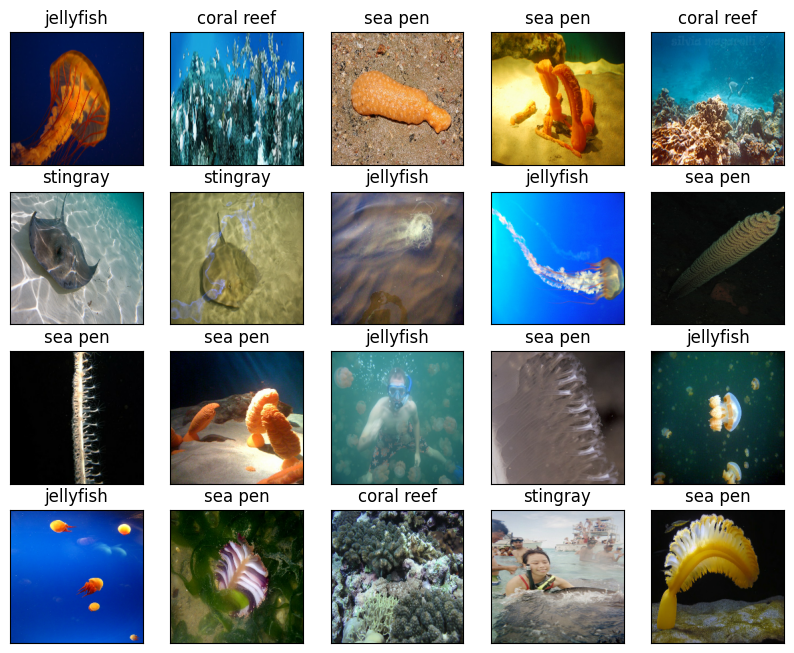

In [9]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_images[i].astype("uint8"))
    plt.title(class_names[(train_labels[i][0])])
    plt.xticks([])
    plt.yticks([])
plt.show()

### **Normalize images**

Before we start with model training we need to perform a normalization of the images; that is, we need the values of the matrices representing the images to be in the set [0,1].

In [10]:
# public Sea animals dataset
normalized_train_images = train_images / 255.0

Check range of normalized image after process

In [11]:
first_image = normalized_train_images[0]
print('Sea Animals: ', np.min(first_image), np.max(first_image))

Sea Animals:  0.0 0.99837464


## **Implement CNN**

One of the most popular deep neural networks is the Convolutional Neural Network (CNN). CNN have multiple layers; including convolutional layer, non-linearity layer, pooling layer and fully-connected layer. The convolutional and fully-connected layers have parameters but pooling and non-linearity layers don't have parameters. The CNN has an excellent performance in machine learning problems.

In [12]:
def cnn(img_path='network_image.png', n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=False):
    num_classes = 4

    inputs = tf.keras.layers.Input(shape=[rows, cols, 3])

    tower_1 = Conv2D(20, (6, 6), padding='valid', strides=(3,3), activation='relu')(inputs)
    tower_1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(tower_1)

    tower_2 = Conv2D(40, (6, 6), padding='valid', strides=(2,2), activation='relu')(tower_1)
    tower_2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_2)

    tower_3 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(tower_2)
    tower_3 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_3)

    tower_4 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(tower_3)
    tower_4 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_4)

    tower_5 = Conv2D(80, (4, 4), padding='same', strides=(3,3), activation='relu')(tower_4)
    tower_5= Dropout(0.2)(tower_5)

    tower_5 = Flatten()(tower_5)

    out = Dense(100, activation='relu')(tower_5)
    out = Dense(num_classes, activation='softmax')(out)

    model = tf.keras.Model(inputs, out)
    # plot_model(model, to_file=img_path)
    return model

There are 3 types of layers in this model:
 - *The convolution layer* is the core building block of the CNN. This layer performs a dot product between two matrices
<div style="text-align: center;"> <img src="Notebook_img/Convolution.webp" style="width:400px;height:400px;"> </div>
The the size of output volume can be determined by the following formula: $$O = \frac{N-F+2P}{S} + 1$$ where N is the size of input image, F is the size of the filter, P is the amount of padding and S is the stride.
 - *The pooling layer* replaces the output of the network at certain locations by deriving a summary statistic of the nearby outputs.  
<div style="text-align: center;"> <img src="Notebook_img/MaxPooling.webp" style="width:400px;height:200px;"> </div>
The the size of output volume can be determined by the following formula: $$O = \frac{N-F}{S} + 1$$ where N is the size of input image, F is the size of the filter and S is the stride.
 - *The fully-connected layer*. This layer is similar to the way that neurons are arranged in a traditional neural network. Therefore, each node in a fully-connected layer is directly connected to every node in both the previous and in the next layer

## **Fuzzy set introduction**

We define a set for example A = {x|x ∈ R and x > 0} where every distinct point in R is either part of our set or not. What we described is the Crisp set theory. Fuzzy sets are also similar to crisp sets but they are more generalized. So crisp sets can be said to be a specific type of fuzzy set. 

Let us define the value 0 and 1 as a membership value ( mA(x)) for crisp sets. It is a binary value i.e it can only be 0 or 1 for crisp sets. For fuzzy sets, this membership value is a continuous value between [0, 1] . In this way fuzzy sets are different from crisp sets. In a fuzzy set, an element’s participation in the set is not strictly defined but it can be a value real between [0, 1] . 


## **Implement Fuzzy block (Inference)**

The Convolutional Fuzzy Neural Network consists of convolutional, pooling and fully-connected layers and a Fuzzy Self Organization Layer. The model combines the power of convolutional neural networks and fuzzy logic and is capable of handling uncertainty and impreciseness in the input pattern representation

In [13]:
# to get all permutaion
fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 

# based on article just 100 of them are needed
out_fRules = random.sample(fRules, n_neurons)

fRules_sigma = K.transpose(out_fRules)

As we can see from the matrix below, each vector i of the matrix fRules_sigma represents the set of rules each element of the input vector x

In [14]:
np.set_printoptions(threshold=sys.maxsize)
print(fRules_sigma)

tf.Tensor(
[[ 1.  1. -1. -1.  1.  0. -1.  1.  1.  1.  0.  1.  0.  1.  0.  1. -1.  0.
   0.  0.  0.  1.  1. -1.  1.  0. -1.  1.  0.  1.  1. -1.  0.  1.  1.  1.
   1.  0. -1.  0.  0.  0. -1. -1.  1.  1.  0.  0. -1.  0. -1. -1.  1.  1.
   1. -1.  0.  1.  1.  0.  0.  1. -1.  1. -1.  0.  1. -1. -1.  0. -1.  0.
   1.  0.  0.  0.  0.  0.  0.  1.  0. -1. -1.  1.  1.  1.  0. -1. -1.  0.
   1.  0.  1.  1.  0. -1.  0.  1.  1.  1.]
 [ 0. -1. -1.  0. -1.  0.  1.  0. -1.  0.  1.  1. -1.  0.  0. -1.  0.  0.
  -1.  1.  1. -1.  1.  0. -1.  1.  1.  0.  1. -1.  0. -1. -1. -1.  1.  1.
   0. -1.  0.  1. -1.  0.  0. -1. -1.  1.  0.  1. -1.  0.  1. -1.  0. -1.
  -1. -1. -1. -1.  1. -1.  0.  0. -1. -1.  1. -1. -1.  0.  0.  0.  0. -1.
   0.  1.  1.  0.  1. -1.  0.  1.  0.  0. -1.  1.  0. -1. -1. -1.  1.  0.
  -1.  0.  0.  0.  0.  1. -1. -1.  1.  0.]
 [ 1.  1. -1. -1. -1.  1.  0.  1. -1. -1.  0.  0. -1.  1.  1.  0. -1.  1.
  -1. -1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1. -1. -1.  0. -1.  0.  0.
  -1. -1.  0.  

The structure of The Fuzzy Layer and the classifier is represented in this figures.
<div style="text-align: center;"> <img src="Notebook_img/CFNN.png" style="width:400px;height:300px;"> </div>
The Fuzzy Layer performs a preliminary input data distribution into a predetermined number of clusters. Note that these clusters are not equivalent to output classes and the number of clusters and target classes can differ.

In [15]:
class fuzzy_inference_block(tf.keras.layers.Layer):
    def __init__(self, output_dim, i_fmap, mu, sigma):

        self.output_dim = output_dim
        self.index = i_fmap
        self.mu = mu
        self.sigma = sigma

        super(fuzzy_inference_block, self).__init__()

    def build(self, input_shape):
        self.mu_map = fRules_sigma * self.mu
        self.sigma_map = tf.ones((n_feature, self.output_dim)) * self.sigma
        

        super().build(input_shape)

    def call(self, inputs):
        fMap = inputs[:,n_feature*(self.index):n_feature*(self.index+1)]
        # create variables for processing
        aligned_x = K.repeat_elements(K.expand_dims(fMap, axis=-1), self.output_dim, -1)
        aligned_c = self.mu_map
        aligned_s = self.sigma_map


        # calculate output of each neuron (fuzzy rule)
        phi = K.exp(-K.sum(K.square(aligned_x - aligned_c) / (2 * K.square(aligned_s)),
                           axis=-2, keepdims=False))
        return phi


## **Implement Fuzzy CNN**

The implementation of Fuzzy CNN is depicted below. As we can see $K$ fuzzy layers are created with $K = N/f$ where $N$ is the number of neurons in the previous layer and $f$ is the number of input neurons for each fuzzy set.

In [16]:
def fcnn(img_path='network_image.png', n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=True):
    # if stride is 3 => size of feature map will be 2x2
    # elif stride is 2 => size of feature map will be 3x3

    num_classes = 4

    inp = Input(shape=[rows, cols, 3])

    conv1 = Conv2D(20, (6, 6), padding='valid', strides=(3,3), activation='relu')(inp)
    conv1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(conv1)

    conv2 = Conv2D(40, (6, 6), padding='valid', strides=(2,2), activation='relu')(conv1)
    conv2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv2)

    conv3 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv2)
    conv3 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv3)

    conv4 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv3)
    conv4 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv4)

    conv5 = Conv2D(n_femap, (4, 4), padding='same', strides=(stride,stride), activation='relu')(conv4)
    if dropout:
       conv5 = Dropout(0.2)(conv5)

    fMaps = Flatten()(conv5)


    fuzzy_inference = []
    n_fuzzy_b = int(np.floor(fMaps.shape[1]/n_feature))
    for i in tqdm(range(n_fuzzy_b)):
        f_block = fuzzy_inference_block(output_dim=n_neurons, i_fmap=i, mu=mu, sigma=sigma)(fMaps)
        fuzzy_inference.append(f_block)
    merged = concatenate(fuzzy_inference, axis=1)

    out = Dense(num_classes, activation='softmax')(merged)

    model = tf.keras.Model(inp, out)

    del inp
    del conv1
    del conv2
    del conv3
    del conv4
    del conv5
    del f_block
    del fuzzy_inference
    del merged
    del out
    gc.collect()
    # plot_model(model, to_file=img_path)

    return model

## **Show Model**

In [17]:
model = fcnn(n_femap=80)
model.summary()

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 69.45it/s]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 65, 65, 20)           2180      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 65, 65, 20)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 30, 30, 40)           28840     ['max_pooling2d[0][0]']   

In [18]:
base_model = cnn()
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 65, 65, 20)        2180      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 65, 65, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 40)        28840     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 40)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 40)        1444

## **Run the Model**

### **Functions to show results**

In [19]:
def show_result(foldperf, scores, nmodel, num_epochs):
    # number of folds
    k=10

    for i, score in enumerate(scores):
        print('Performance of {} fold cross validation'.format(k))
        print("Average model{} Loss: {:.3f}, Average model{} Acc: {:.2f}".format(nmodel[i], np.mean(score[0]) ,nmodel[i] , np.mean(score[1])))


    losses = np.zeros((len(foldperf), num_epochs))
    accs = np.zeros((len(foldperf), num_epochs))

    for j in range(len(foldperf)):
      for i in range(num_epochs):
          losses[j, i] = np.mean([foldperf[j]['fold{}'.format(f+2)].history['loss'][i] for f in range(k)])
          accs[j, i] = np.mean([foldperf[j]['fold{}'.format(f+2)].history['sparse_categorical_accuracy'][i] for f in range(k)])

    # Plot losses
    plt.figure(figsize=(10,8))
    for i in range(len(losses)):
        plt.semilogy(losses[i], label=nmodel[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('loss')
    plt.show()

    # Plot accuracies
    plt.figure(figsize=(10,8))
    for i in range(len(accs)):
        plt.semilogy(accs[i], label=nmodel[i])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()

### **Functions to train model**

In [20]:
kfold = KFold(n_splits=10, shuffle=True)

In [21]:
def train_model(model_func, train_images, train_labels, no_epochs=30, optimizer='adam', n_femap=80, stride=2, mu=3.0, sigma=1.2, dropout=True, show=True):
    foldperf = {}
    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []

    model = scores = history = 1
    
    tf.keras.backend.clear_session()

    # Define the model architecture 
    model = model_func(n_femap=n_femap, stride=stride, mu=mu, sigma=sigma, dropout=dropout)
    # Compile model
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    for test, train in kfold.split(train_images, train_labels):
        
        del history
        del scores

        gc.collect()

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit on data for 30 epochs
        history = model.fit(train_images[train], train_labels[train],
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=show)

        # Generate generalization metrics
        scores = model.evaluate(train_images[test], train_labels[test], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

        foldperf['fold{}'.format(fold_no)] = history  

        # gc.collect()

        

    return model, foldperf, [loss_per_fold, acc_per_fold]

### **To test functions**

In [ ]:
_, foldperf_temp, scores_temp = train_model(fcnn, normalized_train_images, train_labels, no_epochs=400, show=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 70.41it/s]


------------------------------------------------------------------------
Training for fold 1 ...


In [ ]:
_, oldperf_temp_cnn, scores_temp_cnn = train_model(cnn, normalized_train_images, train_labels, no_epochs=400, show=False)

In [ ]:
foldHist =[]
scores = []
foldHist.append(foldperf_temp)
foldHist.append(oldperf_temp_cnn)

scores.append(scores_temp)
scores.append(scores_temp_cnn)

nmodel = [' fcnn', ' cnn']

show_result(foldHist, scores, nmodel, num_epochs=400)